- ***Imports and data loading***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.spatial.distance import cdist
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv('data_football_ratings.csv')
df.dropna(inplace=True)

- ***Data cleaning***

In [3]:
def extract_opponent_and_scores(match_str, team):
    """
    Returns (opp_team, team_score, opp_score).
    - match_str : "France - Romania, 2 - 1"
    - team      : name of the team (e.g., "France" or "Romania")
    """
    pattern = re.compile(r"^([^-]+)\s*-\s*([^,]+),\s*(\d+)\s*-\s*(\d+)$")
    match = pattern.match(match_str)
    if match:
        team1 = match.group(1).strip()
        team2 = match.group(2).strip()
        score1 = int(match.group(3))
        score2 = int(match.group(4))

        if team == team1:
            return (team2, score1, score2)
        elif team == team2:
            return (team1, score2, score1)
        else:
            return (None, None, None)
    else:
        return (None, None, None)

# Create new columns with the extracted infos
df['opp_team'], df['team_score'], df['opp_score'] = zip(*df.apply(
    lambda row: extract_opponent_and_scores(row['match'], row['team']), axis=1
))

df[['match', 'team', 'opp_team', 'team_score', 'opp_score']].head()

,match,team,opp_team,team_score,opp_score
0,"France - Romania, 2 - 1",Romania,France,1,2
1,"France - Romania, 2 - 1",Romania,France,1,2
2,"France - Romania, 2 - 1",Romania,France,1,2
3,"France - Romania, 2 - 1",France,Romania,2,1
4,"France - Romania, 2 - 1",Romania,France,1,2


In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

df['year'] = df['date'].dt.year
df['semester'] = (df['date'].dt.month // 3) + 1

df[['date', 'year', 'semester']].head()

,date,year,semester
0,2016-06-10,2016,3
1,2016-06-10,2016,3
2,2016-06-10,2016,3
3,2016-06-10,2016,3
4,2016-06-10,2016,3


- ***Visualization of Rating Distributions***

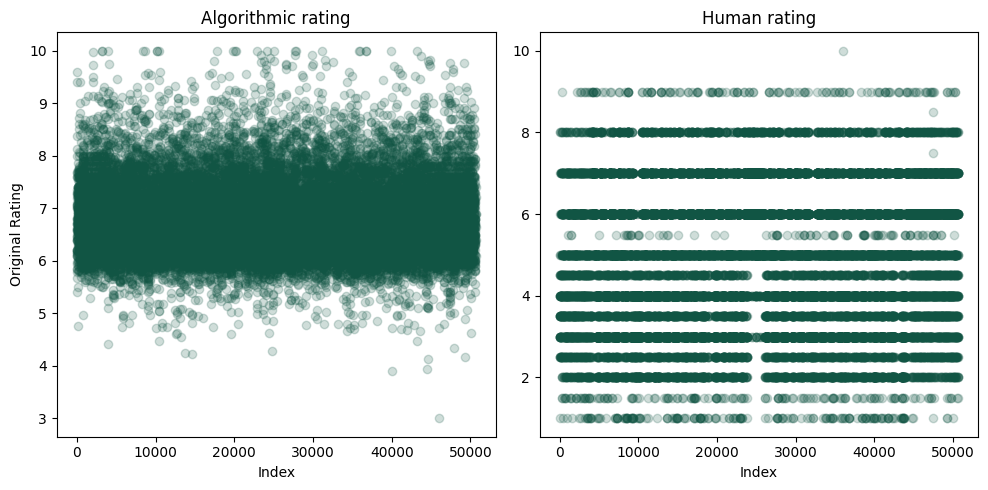

In [5]:
df.drop(columns=['match', 'date', 'player'], inplace=True)
human_0 = df[df['is_human'] == 0]
human_1 = df[df['is_human'] == 1]

# Scatterplot for ratings distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(human_0.index, human_0['original_rating'], alpha=0.2, color='#115544')
plt.title('Algorithmic rating')
plt.xlabel('Index')
plt.ylabel('Original Rating')

plt.subplot(1, 2, 2)
plt.scatter(human_1.index, human_1['original_rating'], alpha=0.2, color='#115544')
plt.title('Human rating')
plt.xlabel('Index')
plt.tight_layout()
plt.show()

***Ratings distributions differ: algorithmic ratings are continuous and densely packed within a narrower range, while human ratings cluster at discrete intervals.***

# **Regression models**

## Function definitions

- **Data preparation:**

In [6]:
def prep_data(df, test_size=0.2, random_state=42):
    # Define categorical and numerical features
    categorical_features = ['competition', 'team', 'opp_team', 'pos', 'pos_role', 'rater']
    numerical_features = [col for col in df.columns if col not in categorical_features + ['original_rating']]

    # One-Hot Encoding and normalization
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Separate features and target variable
    target = 'original_rating'
    X = df.drop(columns=[target])
    y = df[target].values

    # Apply transformations
    X = preprocessor.fit_transform(X)
    X = pd.DataFrame(X.toarray(), columns=preprocessor.get_feature_names_out())

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

- ***Model Architecture:***

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.prelu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.prelu3 = nn.PReLU()
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.fc4 = nn.Linear(hidden_dim3, 1) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.prelu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.prelu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.prelu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = 9 * torch.sigmoid(x) + 1
        return x

def create_model(input_dim, dropout_rate=0.3, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
    return MLP(input_dim, dropout_rate, hidden_dim1, hidden_dim2, hidden_dim3)


- ***Model training:***

In [8]:
def train_model(model, X_train, y_train, X_test, y_test,
                num_epochs=500, criterion=nn.L1Loss(), lr=0.001,
                patience=30, min_delta=0.001, reg_type="none", lambda_reg=0.0):
    """
    reg_type : "none", "l1", "l2" ou "both"
    lambda_reg : coefficient de régularisation
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    best_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, y_train)

        # Regularisation
        if reg_type in ["l1", "both"]:
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_penalty
        if reg_type in ["l2", "both"]:
            l2_penalty = sum((p ** 2).sum() for p in model.parameters())
            loss += lambda_reg * l2_penalty

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test).item()
            test_losses.append(test_loss)

        # Early stopping
        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses, best_model_state, best_epoch


- ***Random search:***


In [9]:
def random_search(X_train, y_train, X_test, y_test, n_iter=10, criterion=nn.L1Loss()):
    best_test_loss = float('inf')
    best_model_state = None
    best_params = None
    best_train_losses = None
    best_test_losses = None

    for i in range(n_iter):
        # Hyperparameter grid:
        lr = 10 ** random.uniform(-4, -2)
        dropout_rate = random.choice([0.0, 0.2, 0.3, 0.4, 0.5])
        hidden_dim1 = random.choice([64, 128, 256])
        hidden_dim2 = random.choice([64, 128])
        hidden_dim3 = random.choice([16, 32])
        reg_type = random.choice(["l1", "l2", "both"])
        lambda_reg = random.choice([0.0, 1e-4, 1e-3, 1e-2])
        num_epochs = 400
        patience = 20

        print(f"\nModel {i+1}/{n_iter} :")
        print(f"  lr = {lr:.5f}; dropout_rate = {dropout_rate}; hidden_dims = ({hidden_dim1}, {hidden_dim2}, {hidden_dim3}); reg_type = {reg_type}; lambda_reg = {lambda_reg}")

        input_dim = X_train.shape[1]
        model = create_model(input_dim, dropout_rate, hidden_dim1, hidden_dim2, hidden_dim3)

        train_losses, test_losses, best_model_state_local, best_epoch_local = train_model(
            model, X_train, y_train, X_test, y_test,
            num_epochs=num_epochs, criterion=criterion, lr=lr,
            patience=patience, min_delta=0.001,
            reg_type=reg_type, lambda_reg=lambda_reg
        )

        final_test_loss = test_losses[-1]
        print(f"Model {i+1} training completed : Final Test Loss = {final_test_loss:.4f} (Best epoch: {best_epoch_local+1})")

        # Update best configuration
        if final_test_loss < best_test_loss:
            best_test_loss = final_test_loss
            best_model_state = best_model_state_local
            best_params = {
                "lr": lr,
                "dropout_rate": dropout_rate,
                "hidden_dim1": hidden_dim1,
                "hidden_dim2": hidden_dim2,
                "hidden_dim3": hidden_dim3,
                "reg_type": reg_type,
                "lambda_reg": lambda_reg,
                "num_epochs": num_epochs,
                "patience": patience,
                "best_epoch": best_epoch_local
            }
            best_train_losses = train_losses
            best_test_losses = test_losses

    print("\nBest Model's Hyperparameters :")
    for i in best_params:
        print(f"  {i} = {best_params[i]}")
    return best_model_state, best_params, best_train_losses, best_test_losses


- ***Evaluation & Visualisation:***

In [10]:
def evaluate(train_losses, test_losses, best_model_state, best_epoch, y_test, x_test, criterion=nn.L1Loss(), discrete=False):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Evaluation
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_pred = np.clip(y_pred, a_min=1, a_max=10)
        if discrete:
            y_pred = np.round(y_pred*2)/2
        test_loss = criterion(torch.tensor(y_pred), y_test).item()
        medae = median_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        close1_pred_percentage = np.mean(abs(np.array(y_test) - np.array(y_pred)) <= 1) * 100
        close05_pred_percentage = np.mean(abs(np.array(y_test) - np.array(y_pred)) <= 0.5) * 100
        exact_pred_percentage = np.mean(np.array(y_test) == np.array(y_pred)) * 100

    # 1st plot: Predictions Scatter Plot
    min_value = min(y_test).item()
    axes[0].set_xticks(np.arange(-1, 11, 1))  # Ajuste en fonction de ton intervalle
    axes[0].set_yticks(np.arange(-1, 11, 1))
    axes[0].grid(True, linestyle='--', linewidth=0.6, alpha=0.8)
    axes[0].scatter(y_test, y_pred, alpha=0.5, color='#99CC99')
    axes[0].plot([min_value, 10], [min_value, 10], 'm--', label="y = x")
    axes[0].set_xlabel("True Rating")
    axes[0].set_ylabel("Predicted Rating")
    axes[0].set_title("Predicted vs. Actual Values")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # 2nd plot: Loss Function
    axes[1].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    axes[1].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', linestyle='--')
    axes[1].axvline(x=best_epoch, color='r', linestyle=':', label='Best Epoch')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("L1 Loss")
    axes[1].set_title("Loss Function Over Training Epochs")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Evaluation metrics
    print(f"\nTest L1 Loss: {test_loss:.4f}")
    print(f"Test MedAE: {medae:.4f}")
    print(f"Test MSE: {mse}\n")
    print(f"Prediction within ±1 from actual value:  {close1_pred_percentage:.2f}%")
    print(f"Prediction within ±.5 from actual value: {close05_pred_percentage:.2f}%\n")
    if discrete:
        print(f"Prediction equal to actual value: {exact_pred_percentage:.2f}%\n")
    pass


## Global Model (both type of ratings)

First we use the entire dataset to train a model that will later serve as a benchmark for evaluating the performance of other models.

In [11]:
# Prepare data
X_train, y_train, X_test, y_test = None, None, None, None
X_train, y_train, X_test, y_test = prep_data(df)

# Run grid-search
best_model_state, best_params, best_train_losses, best_test_losses = random_search(X_train, y_train, X_test, y_test, n_iter=60)


Model 1/60 :
  lr = 0.00017; dropout_rate = 0.3; hidden_dims = (64, 128, 16); reg_type = l1; lambda_reg = 0.01
Epoch 50/400 - Training Loss: 10.6086, Test Loss: 1.3716
Epoch 100/400 - Training Loss: 8.7352, Test Loss: 1.3486
Epoch 150/400 - Training Loss: 7.0993, Test Loss: 1.3256
Epoch 200/400 - Training Loss: 5.7102, Test Loss: 1.3069
Epoch 250/400 - Training Loss: 4.5674, Test Loss: 1.2980
Epoch 300/400 - Training Loss: 3.6710, Test Loss: 1.2940
Early stopping triggered at epoch 309
Model 1 training completed : Final Test Loss = 1.2936 (Best epoch: 289)

Model 2/60 :
  lr = 0.00486; dropout_rate = 0.5; hidden_dims = (128, 128, 16); reg_type = both; lambda_reg = 0.01
Early stopping triggered at epoch 27
Model 2 training completed : Final Test Loss = 1.2944 (Best epoch: 7)

Model 3/60 :
  lr = 0.00128; dropout_rate = 0.0; hidden_dims = (64, 128, 16); reg_type = l1; lambda_reg = 0.01
Epoch 50/400 - Training Loss: 2.9964, Test Loss: 1.2395
Epoch 100/400 - Training Loss: 1.3292, Test Lo

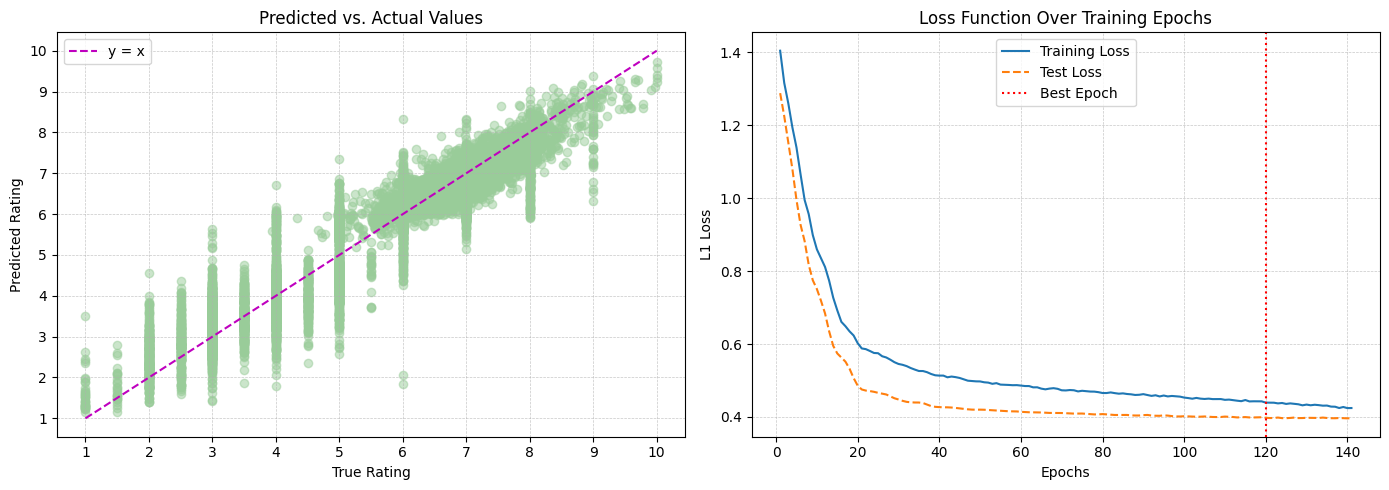


Test L1 Loss: 0.3964
Test MedAE: 0.2820
Test MSE: 0.3007713854312897

Prediction within ±1 from actual value:  92.56%
Prediction within ±.5 from actual value: 70.98%



In [12]:
# Recreate the best model trained
model = create_model(X_test.shape[1],
                     dropout_rate=best_params["dropout_rate"],
                     hidden_dim1=best_params["hidden_dim1"],
                     hidden_dim2=best_params["hidden_dim2"],
                     hidden_dim3=best_params["hidden_dim3"])
model.load_state_dict(best_model_state)

# Evaluate
evaluate(best_train_losses, best_test_losses,
         best_model_state, best_params["best_epoch"],
         y_test, X_test, criterion=nn.L1Loss(), discrete=False)


## Model for Algorithmic Ratings

In [13]:
# Prepare data for bot ratings
X_train, y_train, X_test, y_test = None, None, None, None
X_train, y_train, X_test, y_test = prep_data(human_0)

# Run grid-search
best_model_state_bot, best_params_bot, best_train_losses_bot, best_test_losses_bot = random_search(X_train, y_train, X_test, y_test, n_iter=60)


Model 1/60 :
  lr = 0.00112; dropout_rate = 0.0; hidden_dims = (128, 128, 16); reg_type = l2; lambda_reg = 0.001
Epoch 50/400 - Training Loss: 0.3201, Test Loss: 0.2664
Epoch 100/400 - Training Loss: 0.2818, Test Loss: 0.2552
Epoch 150/400 - Training Loss: 0.2612, Test Loss: 0.2500
Early stopping triggered at epoch 190
Model 1 training completed : Final Test Loss = 0.2485 (Best epoch: 170)

Model 2/60 :
  lr = 0.00017; dropout_rate = 0.4; hidden_dims = (64, 64, 16); reg_type = l1; lambda_reg = 0.01
Epoch 50/400 - Training Loss: 7.5118, Test Loss: 0.7687
Epoch 100/400 - Training Loss: 5.9648, Test Loss: 0.6813
Epoch 150/400 - Training Loss: 4.6492, Test Loss: 0.6117
Epoch 200/400 - Training Loss: 3.5616, Test Loss: 0.5584
Epoch 250/400 - Training Loss: 2.7024, Test Loss: 0.5154
Epoch 300/400 - Training Loss: 2.0605, Test Loss: 0.4822
Epoch 350/400 - Training Loss: 1.6328, Test Loss: 0.4595
Epoch 400/400 - Training Loss: 1.3797, Test Loss: 0.4406
Model 2 training completed : Final Test 

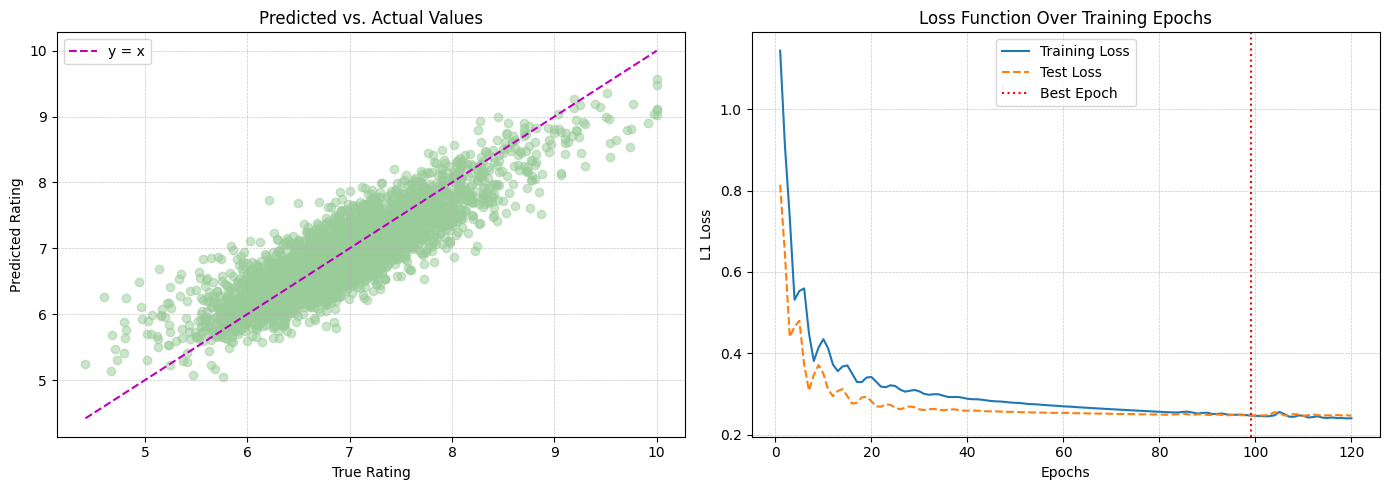


Test L1 Loss: 0.2464
Test MedAE: 0.1943
Test MSE: 0.10513845086097717

Prediction within ±1 from actual value:  99.28%
Prediction within ±.5 from actual value: 88.15%



In [14]:
# Recreate the best model trained
model = create_model(X_test.shape[1],
                     dropout_rate=best_params_bot["dropout_rate"],
                     hidden_dim1=best_params_bot["hidden_dim1"],
                     hidden_dim2=best_params_bot["hidden_dim2"],
                     hidden_dim3=best_params_bot["hidden_dim3"])
model.load_state_dict(best_model_state_bot)

evaluate(best_train_losses_bot, best_test_losses_bot,
         best_model_state_bot, best_params_bot["best_epoch"],
         y_test, X_test, criterion=nn.L1Loss(), discrete=False)

## Model for Human Ratings

In [15]:
# Prepare data for human ratings
X_train, y_train, X_test, y_test = None, None, None, None
X_train, y_train, X_test, y_test = prep_data(human_1)

# Run grid-search
best_model_state_human, best_params_human, best_train_losses_human, best_test_losses_human = random_search(X_train, y_train, X_test, y_test, n_iter=60)


Model 1/60 :
  lr = 0.00014; dropout_rate = 0.4; hidden_dims = (128, 128, 16); reg_type = l1; lambda_reg = 0.0001
Epoch 50/400 - Training Loss: 1.5227, Test Loss: 1.3438
Epoch 100/400 - Training Loss: 1.1868, Test Loss: 0.9478
Epoch 150/400 - Training Loss: 0.9603, Test Loss: 0.6841
Epoch 200/400 - Training Loss: 0.8937, Test Loss: 0.6297
Epoch 250/400 - Training Loss: 0.8443, Test Loss: 0.5996
Epoch 300/400 - Training Loss: 0.8118, Test Loss: 0.5806
Epoch 350/400 - Training Loss: 0.7872, Test Loss: 0.5683
Epoch 400/400 - Training Loss: 0.7662, Test Loss: 0.5607
Model 1 training completed : Final Test Loss = 0.5607 (Best epoch: 393)

Model 2/60 :
  lr = 0.00069; dropout_rate = 0.0; hidden_dims = (128, 64, 16); reg_type = l2; lambda_reg = 0.0001
Epoch 50/400 - Training Loss: 0.6732, Test Loss: 0.6602
Epoch 100/400 - Training Loss: 0.5579, Test Loss: 0.5594
Epoch 150/400 - Training Loss: 0.5200, Test Loss: 0.5446
Early stopping triggered at epoch 195
Model 2 training completed : Final T

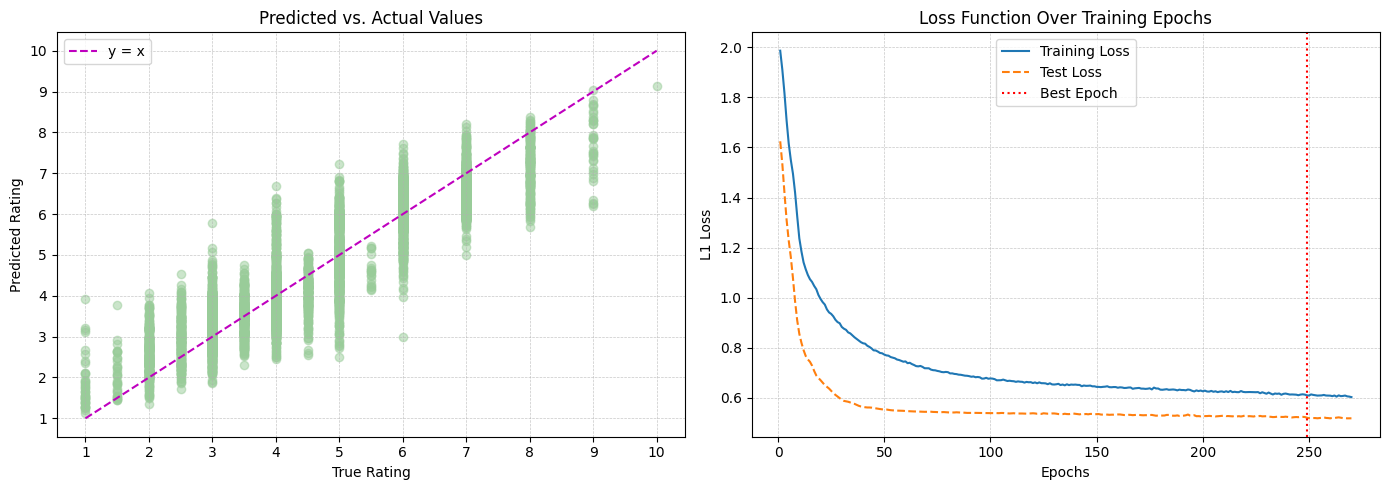


Test L1 Loss: 0.5185
Test MedAE: 0.4160
Test MSE: 0.45837700366973877

Prediction within ±1 from actual value:  87.08%
Prediction within ±.5 from actual value: 56.69%



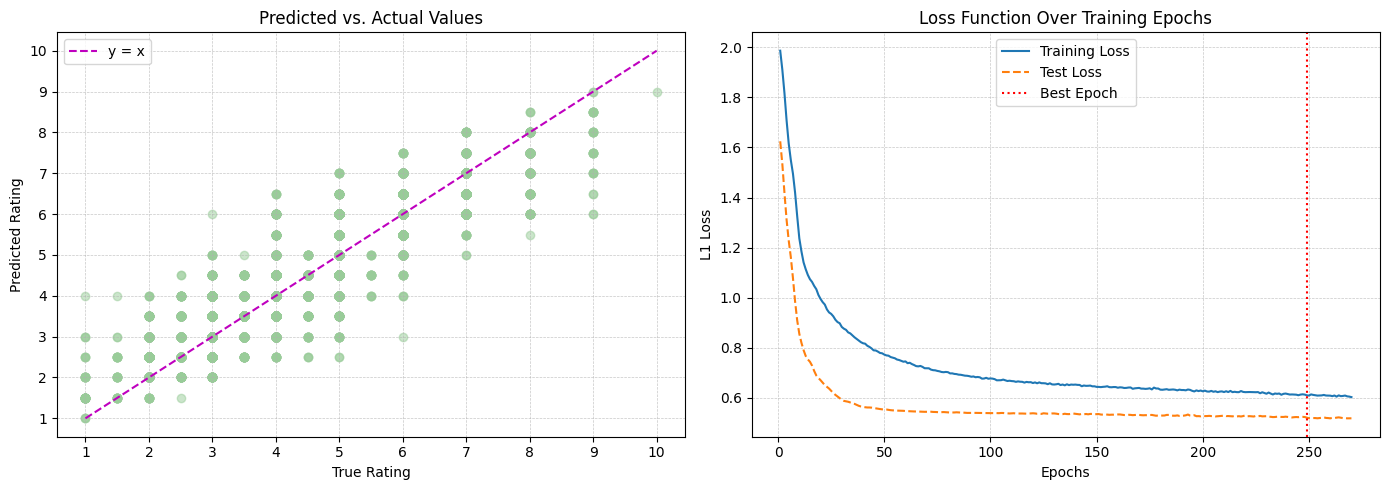


Test L1 Loss: 0.5026
Test MedAE: 0.5000
Test MSE: 0.4794609546661377

Prediction within ±1 from actual value:  93.92%
Prediction within ±.5 from actual value: 73.75%

Prediction equal to actual value: 34.05%



In [16]:
# Recreate the best model trained
model = create_model(X_test.shape[1],
                     dropout_rate=best_params_human["dropout_rate"],
                     hidden_dim1=best_params_human["hidden_dim1"],
                     hidden_dim2=best_params_human["hidden_dim2"],
                     hidden_dim3=best_params_human["hidden_dim3"])
model.load_state_dict(best_model_state_human)

# Evaluate continous predictions
evaluate(best_train_losses_human, best_test_losses_human,
         best_model_state_human, best_params_human["best_epoch"],
         y_test, X_test, criterion=nn.L1Loss(), discrete=False)

# Evaluate discret predictions (rounded)
evaluate(best_train_losses_human, best_test_losses_human,
         best_model_state_human, best_params_human["best_epoch"],
         y_test, X_test, criterion=nn.L1Loss(), discrete=True)

# **Ordinal Classifier for Human Ratings**


As human ratings are discrete, we can treat them as classes and use a classifier to predict the exact ratings.

## Data preparation

In [60]:
df = human_1.copy()

unique_vals = np.arange(0, 10.5, 0.5) # 0 to 10 by .5 increment
rating_to_index = {val: i for i, val in enumerate(unique_vals)}
K = len(unique_vals) # number of class

# Convert rating to a categorical var.
df['rating_class'] = df['original_rating'].map(rating_to_index)
df = df.drop(columns=['original_rating'])
print("Mapping des classes:", rating_to_index)

Mapping des classes: {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 4, 2.5: 5, 3.0: 6, 3.5: 7, 4.0: 8, 4.5: 9, 5.0: 10, 5.5: 11, 6.0: 12, 6.5: 13, 7.0: 14, 7.5: 15, 8.0: 16, 8.5: 17, 9.0: 18, 9.5: 19, 10.0: 20}


In [61]:
# Define categorical and numerical features
categorical_features = ['competition', 'team', 'opp_team', 'pos', 'pos_role', 'rater']
numerical_features = [col for col in df.columns if col not in categorical_features + ['rating_class']]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Separate features and target variable
target = 'rating_class'
X = df.drop(columns=[target])
y = df[target].values

# Apply transformations
X = preprocessor.fit_transform(X)  # Keep as sparse matrix initially
X = pd.DataFrame(X.toarray(), columns=preprocessor.get_feature_names_out())

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

y_train_tensor = y_train_tensor.squeeze().long()
y_test_tensor  = y_test_tensor.squeeze().long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(y_train_tensor.unique())
print(X_train_tensor.unique())
print(y_test_tensor.unique())
print(X_test_tensor.unique())

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18])
tensor([-6.9328, -6.2405, -6.1911,  ..., 16.9766, 20.6378, 22.0911])
tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 18, 20])
tensor([-6.9328, -4.0529, -4.0008,  ..., 16.9766, 20.6378, 22.0911])


## Model architecture

In [62]:
class OrdinalNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.05):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer (logits)
        x = self.fc_out(x)

        return x

# Instanciate the model
model = OrdinalNet(
    input_dim=X_train_tensor.shape[1],  # number of features
    hidden_dim=64,
    num_classes=K
)

# Optimiser
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Custom Loss function

Not all misclassifications are equal since the classes (ratings) follow a natural order, meaning the distance between classes is not uniform. To account for this, we will design a loss function where misclassifying a class as a nearby one will be penalized less than misclassifying it as a much more distant class.

In [63]:
# Matrix of absolute distance (Manhattan)
distance_matrix = cdist(np.arange(K).reshape(-1, 1), np.arange(K).reshape(-1, 1), metric='cityblock')

# Tansformation + Normalisation
distance_matrix = distance_matrix**0.3
distance_matrix = distance_matrix / distance_matrix.max()

distance_df = pd.DataFrame(distance_matrix, index=unique_vals, columns=unique_vals)
print(distance_df.head())

         0.0       0.5       1.0       1.5       2.0       2.5       3.0   \
0.0  0.000000  0.407091  0.501187  0.566014  0.617034  0.659754  0.696845   
0.5  0.407091  0.000000  0.407091  0.501187  0.566014  0.617034  0.659754   
1.0  0.501187  0.407091  0.000000  0.407091  0.501187  0.566014  0.617034   
1.5  0.566014  0.501187  0.407091  0.000000  0.407091  0.501187  0.566014   
2.0  0.617034  0.566014  0.501187  0.407091  0.000000  0.407091  0.501187   

         3.5       4.0       4.5   ...      5.5       6.0       6.5   \
0.0  0.729828  0.759658  0.786980  ...  0.835812  0.857917  0.878768   
0.5  0.696845  0.729828  0.759658  ...  0.812252  0.835812  0.857917   
1.0  0.659754  0.696845  0.729828  ...  0.786980  0.812252  0.835812   
1.5  0.617034  0.659754  0.696845  ...  0.759658  0.786980  0.812252   
2.0  0.566014  0.617034  0.659754  ...  0.729828  0.759658  0.786980   

         7.0       7.5       8.0       8.5       9.0       9.5       10.0  
0.0  0.898523  0.917315  0.9

In [64]:
def ordinal_distance_loss(logits, targets, distance_matrix):
    """
    Loss computation based on the distance between ordinal classes.

    Arguments:
    - logits: Tensor of shape (batch_size, K), containing unnormalized scores.
    - targets: Tensor of shape (batch_size,), containing integer values representing the target classes [0..K-1].
    - distance_matrix: Tensor of shape (K, K), where D[i, j] represents the distance between classes i and j.

    Returns:
    - loss: Scalar tensor, representing the average loss over the batch.
    """
    # Convert `distance_matrix` to a tensor
    #if not isinstance(distance_matrix, torch.Tensor):
    distance_matrix = torch.tensor(distance_matrix, dtype=torch.float32, device=logits.device)

    # Validate the targets
    if not (targets.dtype == torch.long and targets.ndim == 1):
        raise ValueError("The `targets` must be a `torch.LongTensor` tensor and have 1 dimension.")

    # Apply softmax to logits to obtain probabilities (batch_size, K)
    probs = F.softmax(logits, dim=1)

    # Validate the values of the targets
    if targets.min() < 0 or targets.max() >= distance_matrix.shape[0]:
        raise ValueError(f"The values of `targets` must be in the range [0, {distance_matrix.shape[0] - 1}].")

    # Index the distance_matrix using targets to obtain the associated distances (batch_size, K)
    dist_for_each_target = distance_matrix[targets]  # Select distances for each target class

    # Compute the loss: weighted sum of distances by the predicted probabilities
    loss = (probs * dist_for_each_target).sum(dim=1).mean()

    return loss

def evaluate_loss(model, data_loader, distance_matrix):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for Xb, yb in data_loader:
            logits = model(Xb)
            loss = ordinal_distance_loss(logits, yb, distance_matrix)
            batch_size = Xb.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
    return total_loss / total_samples


## Training

In [65]:

epochs = 500
train_losses = []
test_losses = []

best_model_state = None
best_epoch = 0
best_test_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_loss = 0.0
    nb_train_samples = 0

    for Xb, yb in train_loader:
        logits = model(Xb)
        loss = ordinal_distance_loss(logits, yb, distance_matrix)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = Xb.size(0)
        epoch_train_loss += loss.item() * batch_size
        nb_train_samples += batch_size

    # Average loss over the entire training set
    epoch_train_loss /= nb_train_samples
    train_losses.append(epoch_train_loss)

    # Evaluation on the test set
    epoch_test_loss = evaluate_loss(model, test_loader, distance_matrix)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_epoch = epoch
        best_model_state = model.state_dict().copy()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} "
              f"- Train Loss: {epoch_train_loss:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}")

# Reload the best model after training
model.load_state_dict(best_model_state)
print(f"The best model during training was found at epoch {best_epoch} "
          f"with a test loss of {best_test_loss:.4f}.")

Epoch 20/500 - Train Loss: 0.2663, Test Loss: 0.2846
Epoch 40/500 - Train Loss: 0.2547, Test Loss: 0.2861
Epoch 60/500 - Train Loss: 0.2506, Test Loss: 0.2872
Epoch 80/500 - Train Loss: 0.2458, Test Loss: 0.2853
Epoch 100/500 - Train Loss: 0.2446, Test Loss: 0.2859
Epoch 120/500 - Train Loss: 0.2312, Test Loss: 0.2788
Epoch 140/500 - Train Loss: 0.2275, Test Loss: 0.2780
Epoch 160/500 - Train Loss: 0.2194, Test Loss: 0.2771
Epoch 180/500 - Train Loss: 0.2169, Test Loss: 0.2720
Epoch 200/500 - Train Loss: 0.2147, Test Loss: 0.2729
Epoch 220/500 - Train Loss: 0.2116, Test Loss: 0.2741
Epoch 240/500 - Train Loss: 0.2109, Test Loss: 0.2760
Epoch 260/500 - Train Loss: 0.2091, Test Loss: 0.2748
Epoch 280/500 - Train Loss: 0.2057, Test Loss: 0.2743
Epoch 300/500 - Train Loss: 0.2064, Test Loss: 0.2754
Epoch 320/500 - Train Loss: 0.2041, Test Loss: 0.2762
Epoch 340/500 - Train Loss: 0.2035, Test Loss: 0.2736
Epoch 360/500 - Train Loss: 0.2014, Test Loss: 0.2744
Epoch 380/500 - Train Loss: 0.20

## Results

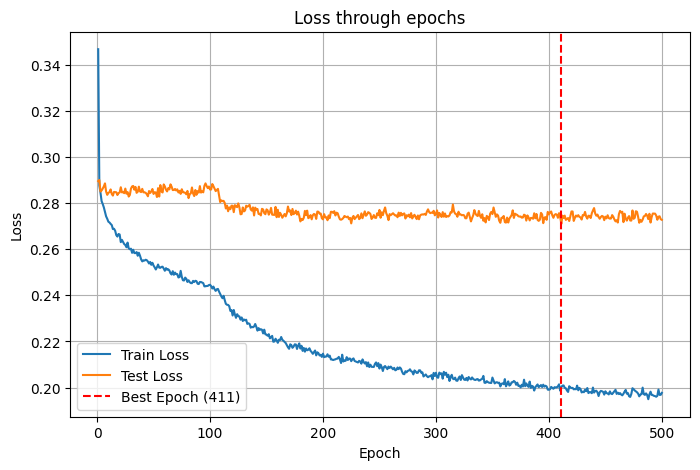

In [66]:
# Test vs Train Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss through epochs')
plt.legend()
plt.grid(True)
plt.show()

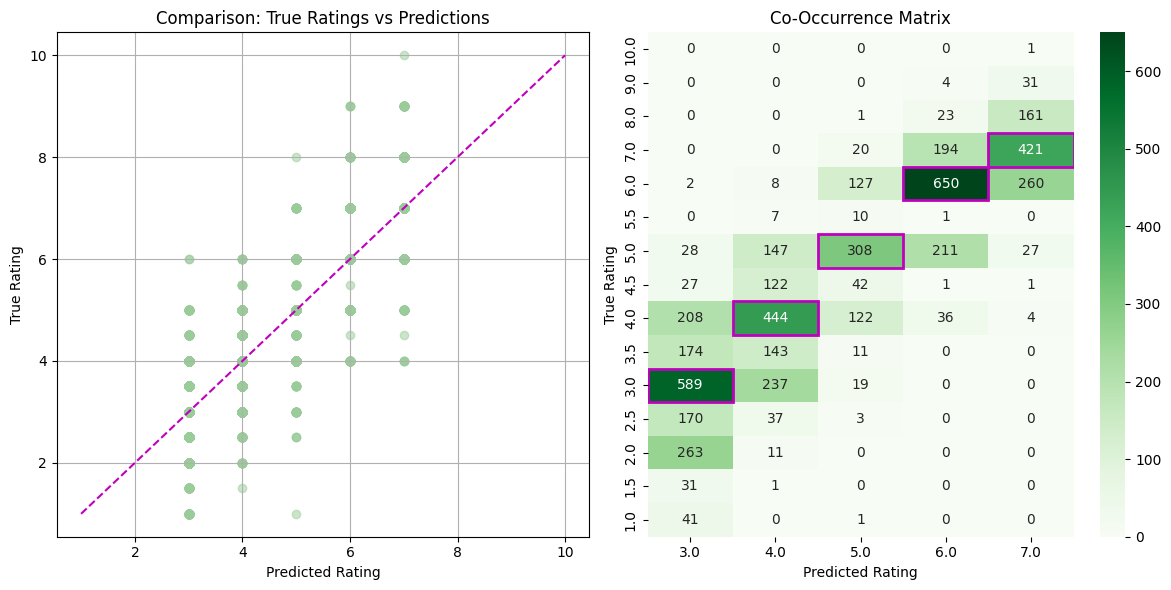

Mean Absolute Error (MAE)  : 0.5525

Prediction within ±1 from actual value:	 93.01%
Prediction within ±.5 from actual value: 57.14%

Prediction equal to actual value: 	 44.83%



In [67]:
# Evaluate the model
model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor)
    probs_test  = F.softmax(logits_test, dim=1)
    pred_classes = probs_test.argmax(dim=1)  # indices [0..K-1]

# Reconstruct the actual ratings from the classes
pred_ratings = [unique_vals[int(c)] for c in pred_classes]
true_ratings = [unique_vals[int(t)] for t in y_test_tensor]


# Visualise results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(pred_ratings, true_ratings, alpha=0.5, color='#99CC99')
ax1.plot([np.min(true_ratings), np.max(true_ratings)],
         [np.min(true_ratings), np.max(true_ratings)], 'm--', label="y = x")
ax1.set_ylabel("True Rating")
ax1.set_xlabel("Predicted Rating")
ax1.set_title("Comparison: True Ratings vs Predictions")
ax1.grid(True)

# Co-occurrence matrix
occurrence_matrix = pd.crosstab(pd.Series(true_ratings, name="True Rating"),
                                pd.Series(pred_ratings, name="Predicted Rating"))

ax2 = axes[1]
sns.heatmap(occurrence_matrix, annot=True, fmt="d", cmap="Greens", cbar=True, ax=ax2)
ax2.invert_yaxis()


# Highlight perfect pred.
true_values = occurrence_matrix.index.tolist()
pred_values = occurrence_matrix.columns.tolist()
for val in true_values:
    if val in pred_values:  # Check if the value exists in both axes
        x = pred_values.index(val)
        y = true_values.index(val)
        ax2.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='m', lw=2))

ax2.set_xlabel("Predicted Rating")
ax2.set_ylabel("True Rating")
ax2.set_title("Co-Occurrence Matrix")


plt.tight_layout()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(true_ratings, pred_ratings)
ok_range_percentage = np.mean(abs(np.array(true_ratings) - np.array(pred_ratings))<=1) * 100
good_range_percentage = np.mean(abs(np.array(true_ratings) - np.array(pred_ratings))<=.5) * 100
exact_match_percentage = np.mean(np.array(true_ratings) == np.array(pred_ratings)) * 100

print(f"Mean Absolute Error (MAE)  : {mae:.4f}\n")
print(f"Prediction within ±1 from actual value:\t {ok_range_percentage:.2f}%")
print(f"Prediction within ±.5 from actual value: {good_range_percentage:.2f}%\n")
print(f"Prediction equal to actual value: \t {exact_match_percentage:.2f}%\n")
